This notebook generates plots for Gaussian Process Regression (GPR) for one dimension data. 
The code refers [Sklearn library](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    # return x * np.sin(x) - 0.8 * (x -2.5)
    return 2 * np.sin(x)
    #return - np.poly1d([1,2,3,4], True)(0.3 * (x+ 2)) 
    

In [2]:
def gpr_plot(X, y, x, rec_size = 1, design_dist = 5, title = 'GPR'):
    """
    X: x train
    y: y train
    x: x test
    rec_size: ucb rec size
    design_dist: x[::design_dist] indicates design space
    title: for plot
    """

    # Instantiate a Gaussian Process model
    # kernel = C(1.0, (1e-3, 1e3)) * RBF(0.6, (1e-2, 1e2))
    # use fixed hyperparameters
    kernel = C(2) * RBF(1)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1,
                                  n_restarts_optimizer=0,#)
                                 optimizer=None)
    
    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)
    print(gp.kernel_)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(x, return_std=True)
    
    # recommendations
    rec_idx = np.argsort(y_pred[::design_dist] + 1.9600 * sigma[::design_dist])[-rec_size:]
    rec = x_test[::design_dist][rec_idx]
    
    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    plt.figure()
    ymin = -5
    ymax = 5
    plt.vlines(rec, ymin, ymax, color = 'r', linestyle = 'dashed', label = 'Recommendations')
    plt.plot(x, f(x), 'g:', label='True function')
    plt.plot(X, y, 'g.', markersize=10, label='Observations')

    plt.plot(x, y_pred, '-', label='Prediction')
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.3, ec='None', label='Confidence interval')
    plt.plot(x[::design_dist], (y_pred + 1.96 * sigma)[::design_dist], marker = '.', label = 'ucb scores')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(ymin, ymax)
    plt.xlim(-2,10)
#     plt.legend(loc='upper left')
    lgd = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title(title)
    plt.savefig(title.replace(' ', '_')+'.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    return y_pred, sigma, rec_idx

In [3]:
# x_test = np.atleast_2d(np.linspace(0, 10, 101)).T
x_test = np.atleast_2d(np.linspace(-2, 10, 121)).T
design_dist = 5
x_design = x_test.reshape(-1,)[::design_dist]
noise = np.random.normal(0, 0.05)

# init
X = np.atleast_2d([-1, 1, 5., 6., 9]).T
# Observations
y = f(X).ravel() + noise

In [4]:
x_test.reshape(-1,)[::5]

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,
        3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,
        9. ,  9.5, 10. ])

In the following, we show the batch recommendations based on the upper confidence bound algorithm.
We consider the batch size 2, with 5 initial observations.
The design (recommendation) space is 24 uniformly distributed points in the range [-2,10], i.e. {-2, -1.5, -1, ..., 9.5, 10}.   
One naive approach is to train GPR on sequences with known TIR labels and recommend sequences in design space with top $n = 2$ UCB scores.

1.41**2 * RBF(length_scale=1)


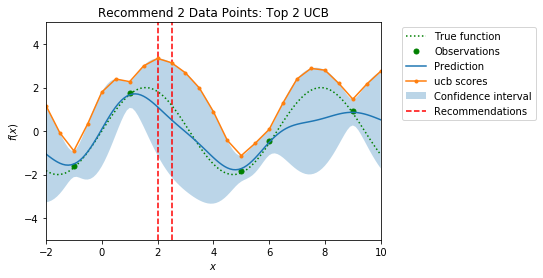

In [5]:
top2_pred, top2_sigma, top2_rec = gpr_plot(X, y,x_test, rec_size = 2, title = 'Recommend 2 Data Points: Top 2 UCB')

The GP-BUCB approach is designed to reduce the similarity between the recommendations in a batch.  
It recommends data point sequentially by assuming have seen the previous recommended points and updating the UCB score with the updated predicted SD.   
In our toy example, GP-BUCB firstly recommend the data point with maximum UCB scores based on the predictions over initial 5 observations. As shown in the following first plot.  
Then we add the recommended data point (x = 2) into training data with the predicted mean as label (note it is not the true label, i.e. observation), and recommend the second data point based on the new predictions.   
As we can see, since we assume we have observed x = 2, then the new predicted variance of the data points in design space around x =2  decreases, so instead of recommending a similar data point x = 2.5, we recommend the data point which is in another area and potentially having high labels (x = 7.5).     
By using BUCB, we rule out the sequences with high similarities in the same batch and increase the exploration efficiency. 

1.41**2 * RBF(length_scale=1)
1.41**2 * RBF(length_scale=1)


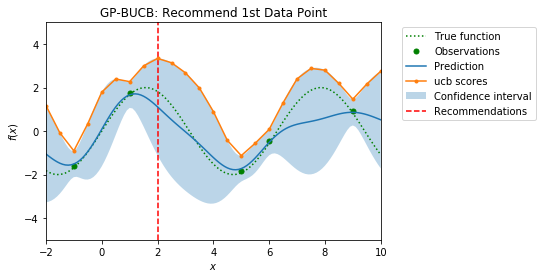

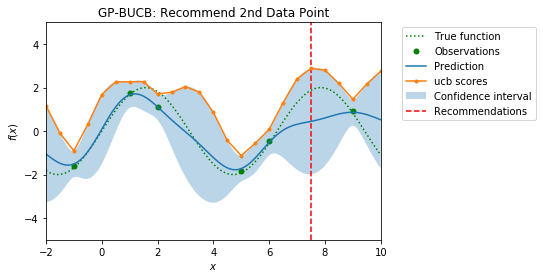

In [6]:
# GPBUCB
design_dist = 5

# rec1
y_pred, sigma, rec = gpr_plot(X,y, x_test, title = 'GP-BUCB: Recommend 1st Data Point')

# rec2
obs_y = y_pred[::design_dist][rec] 
batch_new_y = np.append(y, obs_y)
batch_new_X = np.append(X.reshape(-1,), x_test[::design_dist][rec]).reshape(-1,1)

batch_new_pred, batch_new_sigma, batch_rec = gpr_plot(batch_new_X,batch_new_y,x_test, title = 'GP-BUCB: Recommend 2nd Data Point') 